In [92]:
from mass_spectra.train_spec2vec import preprocess_file
import re
import pandas as pd
import os
from matplotlib import pyplot as plt

In [93]:
def peaks_processor(line):
    peaks = line.split(";")
    output = ""
    for p in peaks:
        p = p.strip()
        if p == "":
            continue
        mz, intensity = p.split(" ")
        output += f"{mz} {intensity}\n"
    return output

def mz_processor(line):
    return line + "\n"

In [94]:
# for NIST
# data_processor = peaks_processor
# encoding = 'utf-8'
# metadata_path = './source/dataset/Metadata_training_TMS derivatives_3.1.xlsx'
# test_txt = "./source/dataset/other/Train NIST 3.1 dataset_TMS_BS.txt"
# test_mgf = "./source/dataset/Train NIST 3.1 dataset_TMS_BS.mgf"
# INCHI_KEY = 'InChIKey'
# EXACT_MASS = 'Exact mass'
# NAME = 'Name'

# for Milka
data_processor = mz_processor
encoding = 'utf-16'
metadata_path = './source/dataset/Metadata_test_TMS_derivatives.xlsx'
test_txt = "./source/dataset/other/Test Milka dataset_TMS_BS.txt"
test_mgf = "./source/dataset/Test Milka dataset_TMS_BS.mgf"
INCHI_KEY = 'InChI Key'
EXACT_MASS = 'Exact mass'
NAME = 'Name'

In [95]:
metadata_df = pd.read_excel(metadata_path)
metadata_df.columns

Index(['Name', 'Molecular formula', 'Exact mass', 'PubChem ID', 'InChI',
       'InChI Key', 'SMILEs', 'Parent compound', 'Molecular formula.1',
       'Exact mass.1', 'PubChem ID.1', 'InChI parent', 'InChI Key parent',
       'SMILEs parent', 'present_in_train_dataset'],
      dtype='object')

In [96]:
assert INCHI_KEY in metadata_df.columns
assert EXACT_MASS in metadata_df.columns
assert NAME in metadata_df.columns

In [97]:
# remove rows without inchi key
metadata_df = metadata_df[~metadata_df[INCHI_KEY].isna()]

In [98]:
metadata_df[INCHI_KEY] = metadata_df[INCHI_KEY].apply(lambda x: x.strip())
metadata_df[NAME] = metadata_df[NAME].apply(lambda x: x.strip())

In [99]:
assert os.path.exists(test_txt)
assert os.path.exists(test_mgf)

In [100]:
BEGIN_REGEX = r'^[0-9]+[\.\,\s]*Name:\s?(.*)'
DATA_INDICATOR = ["m/z", "peak"]

In [101]:
found_inchi_keys = set()
missing_inchi_keys = set()
extracted_from_text = set()
expected_spectra = 0
data_dict = []
with open(test_txt, 'r', encoding=encoding) as file, open(test_mgf, 'w', encoding='utf-8') as output:
    inchi_key = None
    data = False
    name = None
    exact_mass = None
    for line in file:
        line = line.strip()
        if line == "":
            continue
        m = re.match(BEGIN_REGEX, line)
        if m:
            expected_spectra += 1
            if data:
                output.write("\n")
                output.write("END IONS\n")
                output.write("\n")
            inchi_key = None
            data = False
            name = m.group(1)
            exact_mass = None
        elif line.startswith("InChIKey"):
            inchi_key = line.split("InChIKey:")[1].strip()
            extracted_from_text.add(inchi_key)
        elif line.startswith("ExactMass:"):
            charachters = [x for x in line.split("ExactMass:")[1].strip() if x.isdigit() or x == "."]
            exact_mass = float("".join(charachters))
        elif inchi_key is not None and exact_mass is None:
            inchi_key_info = metadata_df[metadata_df[INCHI_KEY] == inchi_key]
            if len(inchi_key_info) == 0:
                missing_inchi_keys.add(inchi_key)
                continue
            found_inchi_keys.add(inchi_key)
            inchi_key_info = inchi_key_info.iloc[0]
            exact_mass = inchi_key_info[EXACT_MASS]
            name = inchi_key_info[NAME]
        elif any([x in line for x in DATA_INDICATOR]):
            if inchi_key is None or name is None or exact_mass is None:
                continue
            data_dict.append({
                "inchi_key": inchi_key,
                "name": name,
                "exact_mass": exact_mass,
            })
            output.write("BEGIN IONS\n")
            output.write("MASS=" + str(exact_mass) + "\n")
            output.write("CHARGE=+1\n")
            title = "InChIKey: " + inchi_key + ", Name:" + name
            output.write("TITLE=" + title + "\n")
            inchi_key = None
            name = None
            exact_mass = None
            data = True
        elif data:
            line = re.sub(r"\s+", " ", line)
            line = data_processor(line)
            output.write(line)
    if data:
        output.write("\n")
        output.write("END IONS\n")

In [ ]:
data_df = pd.DataFrame(data_dict)
data_df = data_df.drop_duplicates()
if os.path.exists("./source/dataset/names_masses.csv"):
    old_data_df = pd.read_csv("./source/dataset/names_masses.csv")
    data_df = pd.concat([old_data_df, data_df])
data_df = data_df.drop_duplicates()
data_df.to_csv("./source/dataset/names_masses.csv", index=False)

In [ ]:
len(data_df)

In [ ]:
print("Unqiue inchi keys found:", len(found_inchi_keys))

Unqiue inchi keys found: 3730


In [ ]:
print("Extracted from text:")
for key in (extracted_from_text - found_inchi_keys):
    print(key)

Extracted from text:
CUFZSXJWQGLDNJ-UHFFFAOYSA-N
N
VYKNVWCCWFXWCV-VVEOGCPPSA-N
GYUFBIVZHBEQFU-MRBUWEIXSA-N
NPLBCEVMVMARTI-UHFFFAOYSA-N
JZAWIXTULQNFBY-SJUREKTCSA-N
WWTNNUWODYMBCZ-LWQDQPMZSA-N
JMTIIUMYXHQPNT-WUKNDPDISA-N
KZRLNPJKVJFPRT-VOTSOKGWSA-N
NVMUYCQWCVKJOU-UHFFFAOYSA-N
NSRYHLHYPBHYSV-IPBVOBEMSA-N
OAQUHIASABQRCB-UHFFFAOYSA-N
KXBNDDHLERLHTO-NBVRZTHBSA-N
RBSXFFWTNZTHKA-GIIZWKBWSA-N
RYQGQTNCWAYNRA-UHFFFAOYSA-N
XOWGRYAVMBGHMT-JBPAQATLSA-N
KDOXUCXXSCGCSY-VOTSOKGWSA-N
WMJQNCOTNSSCLS-UHFFFAOYSA-N
IUQZNKXBZASJRQ-UHFFFAOYSA-N
FNMCFHULWPLYIO-QVIHXGFCSA-N
FHCJZXXFOQBSQH-YENZWQNZSA-N
HNCGPAHGPSVGOW-UHFFFAOYSA-N
OMKOROOXWADNNN-UHFFFAOYSA-N
CISBSUGRAJLSLW-UFJIVRMCSA-N
PYZYLQABQPEYLJ-UHFFFAOYSA-N
HSRKDSBJGBYTLC-HXJOAWKQSA-N
DWPLBGUPOMDHNU-UHFFFAOYSA-N
UNWYAWOUVRQTMC-UHFFFAOYSA-N
HXZDPNZUOMMRAW-UHFFFAOYSA-N
RAGCOUJICMBPCU-UHFFFAOYSA-N
WEDOPALXSTVHSM-ACCUITESSA-N


In [ ]:
print("Missing inchi keys: ")
for key in missing_inchi_keys:
    print(key)

Missing inchi keys: 
CUFZSXJWQGLDNJ-UHFFFAOYSA-N
N
VYKNVWCCWFXWCV-VVEOGCPPSA-N
GYUFBIVZHBEQFU-MRBUWEIXSA-N
NPLBCEVMVMARTI-UHFFFAOYSA-N
JZAWIXTULQNFBY-SJUREKTCSA-N
WWTNNUWODYMBCZ-LWQDQPMZSA-N
JMTIIUMYXHQPNT-WUKNDPDISA-N
KZRLNPJKVJFPRT-VOTSOKGWSA-N
NVMUYCQWCVKJOU-UHFFFAOYSA-N
NSRYHLHYPBHYSV-IPBVOBEMSA-N
OAQUHIASABQRCB-UHFFFAOYSA-N
KXBNDDHLERLHTO-NBVRZTHBSA-N
RBSXFFWTNZTHKA-GIIZWKBWSA-N
RYQGQTNCWAYNRA-UHFFFAOYSA-N
XOWGRYAVMBGHMT-JBPAQATLSA-N
KDOXUCXXSCGCSY-VOTSOKGWSA-N
WMJQNCOTNSSCLS-UHFFFAOYSA-N
IUQZNKXBZASJRQ-UHFFFAOYSA-N
FNMCFHULWPLYIO-QVIHXGFCSA-N
FHCJZXXFOQBSQH-YENZWQNZSA-N
HNCGPAHGPSVGOW-UHFFFAOYSA-N
OMKOROOXWADNNN-UHFFFAOYSA-N
CISBSUGRAJLSLW-UFJIVRMCSA-N
PYZYLQABQPEYLJ-UHFFFAOYSA-N
HSRKDSBJGBYTLC-HXJOAWKQSA-N
DWPLBGUPOMDHNU-UHFFFAOYSA-N
UNWYAWOUVRQTMC-UHFFFAOYSA-N
HXZDPNZUOMMRAW-UHFFFAOYSA-N
RAGCOUJICMBPCU-UHFFFAOYSA-N
WEDOPALXSTVHSM-ACCUITESSA-N


In [ ]:
print("Unused inchi keys in metadata: ")
for key in (set(metadata_df[INCHI_KEY]) - found_inchi_keys):
    print(key)

Unused inchi keys in metadata: 

XMFGXIHIZQNSEM-UHFFFAOYSA-N
WWTNNUWODYMBCZ-UHFFFAOYSA-N
ITGKZNAFHOGTIJ-DRRXZNNHSA-N
XLRGOJXBHQUFLI-UHFFFAOYSA-N
KNAZTEWBFRPMHZ-DZTJYMNTSA-N
XNIHRKNDAXXBPD-CUVVAGTFSA-N
PYHVQDNQPUVBIE-DAMHEBELSA-N
KXBNDDHLERLHTO-UHFFFAOYSA-N
FKAKIAINQCBRDM-UHFFFAOYSA-N
VLLJOGZFMDUFGI-UHFFFAOYSA-N
JMTIIUMYXHQPNT-UHFFFAOYSA-N
NYLWRGDNDMJYNX-UHFFFAOYSA-N
WEDOPALXSTVHSM-UHFFFAOYSA-N
NSRYHLHYPBHYSV-UHFFFAOYSA-N
SOGDCAWGODWBMZ-UHFFFAOYSA-N
BUSWZLLZADFTRZ-UHFFFAOYSA-N
VYKNVWCCWFXWCV-UHFFFAOYSA-N
FNMCFHULWPLYIO-UHFFFAOYSA-N
GRQGMVRZMUHBDW-UHFFFAOYSA-N
GYUFBIVZHBEQFU-AQASXUMVSA-N
KDOXUCXXSCGCSY-SREVYHEPSA-N


In [ ]:
print("Expected spectra: ", expected_spectra)

Expected spectra:  4650


In [ ]:
spectra = preprocess_file(test_mgf, convert_to_document=False)
len(spectra)

KeyboardInterrupt: 

In [ ]:
spectra = [s for s in spectra if s is not None]
len(spectra)

2969

Text(0.5, 1.0, '')

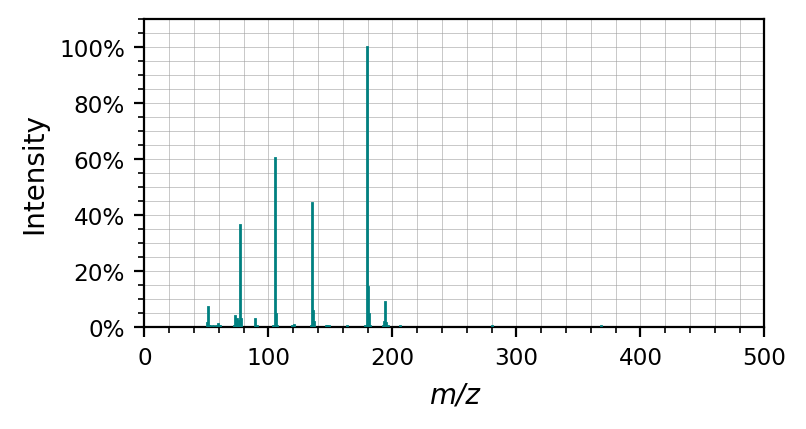

In [ ]:
spectra[0].plot(figsize=(4, 2))
plt.title("")

Text(0, 0.5, 'Number of spectra')

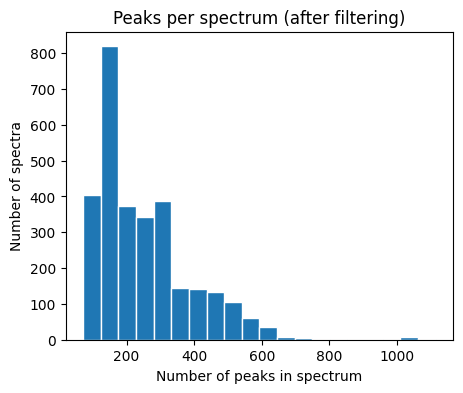

In [ ]:
numbers_of_peaks = [len(s.peaks.mz) for s in spectra]
plt.figure(figsize=(5,4), dpi=100)
plt.hist(numbers_of_peaks, 20, edgecolor="white")
plt.title("Peaks per spectrum (after filtering)")
plt.xlabel("Number of peaks in spectrum")
plt.ylabel("Number of spectra")